In [40]:
#perform neighbor enrichment analysis with squidpy
import anndata
import pandas as pd
import squidpy as sq
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib as mpl
import time, os, sys
import glob
import warnings
import numpy as np
import seaborn as sns
warnings.simplefilter(action='ignore', category=FutureWarning)

In [42]:
#import simualted data
path_to_csv = './../../../SCNA_thesis/data/20250217_sym00_nbh2_1000dim_grid200_300iter_50swaps/'

# Use glob to get all the CSV files in the folder
csv_files = glob.glob(os.path.join(path_to_csv, '*.csv'))

# Initialize an empty list to store individual DataFrames
data_frames = []

# Loop through the CSV files and process each one
for file in csv_files:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file)

    # Extract the file name without the extension and path
    sample_id = os.path.splitext(os.path.basename(file))[0]

    # Add a new column for the sample ID
    df['sample_id'] = sample_id

    # Append the DataFrame to the list
    data_frames.append(df)

# Concatenate all DataFrames into one big DataFrame
obs = pd.concat(data_frames, ignore_index=True)


In [43]:
# add marker files to it, as SpatialLDA needs them
obs['D'] = np.random.randint(1, 101, size=len(obs))
obs['E'] = np.random.randint(1, 101, size=len(obs))

# Load dataframe into anndata object
# dataframe for annotating the observations
obs = obs.astype({'ct':'string'})

# the data matrix 
X = obs[['D', 'E']]
X = X.values
adata = anndata.AnnData(X)
adata.obs = obs

adata.obs

,x,y,ct,sample_id,D,E
0,0.000000,0.000000,1.0,self00_0.6_ab0_0.15_13,81,33
1,24.534492,0.000000,0.0,self00_0.6_ab0_0.15_13,73,98
2,52.289758,0.000000,0.0,self00_0.6_ab0_0.15_13,61,56
3,79.509940,0.000000,2.0,self00_0.6_ab0_0.15_13,11,67
4,102.494435,0.000000,2.0,self00_0.6_ab0_0.15_13,40,100
...,...,...,...,...,...,...
4283227,1000.000000,507.264433,2.0,self00_0.6_ab0_0.05_7,85,33
4283228,187.994456,853.032888,1.0,self00_0.6_ab0_0.05_7,86,17
4283229,155.090592,758.147251,0.0,self00_0.6_ab0_0.05_7,45,85
4283230,977.121401,36.181175,1.0,self00_0.6_ab0_0.05_7,84,92


In [44]:
# get spatial coordinates to be in obsm
adata.obsm['spatial'] = obs[['x', 'y']].values
# make "refined_cell_types" a categorical variable
adata.obs['ct'] = pd.Categorical(adata.obs['ct'])


In [45]:

# Assuming 'FOV' is the column in obs indicating different fields of view
fov_list = adata.obs['sample_id'].unique()

# Dictionary to store FOV-specific AnnData objects
fov_adata_dict = {}

# Loop over each FOV
for fov in fov_list:
    # suppress warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)
    # Create a subset of adata for the specific FOV
    fov_adata = adata[adata.obs['sample_id'] == fov].copy()

    # Perform spatial neighbors analysis on the subset
    sq.gr.spatial_neighbors(fov_adata, coord_type = 'generic', delaunay=True)
    sq.gr.nhood_enrichment(fov_adata, cluster_key="ct", n_perms=300, seed=fov_list.tolist().index(fov), show_progress_bar=False)
    # Store the result in the dictionary
    fov_adata_dict[fov] = fov_adata


/Users/chiaraschiller/miniconda3/envs/squidpy_MI/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/chiaraschiller/miniconda3/envs/squidpy_MI/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/chiaraschiller/miniconda3/envs/squidpy_MI/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/chiaraschiller/miniconda3/envs/squidpy_MI/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/chiaraschiller/miniconda3/env

In [49]:
def flatten_zscore_matrices(fov_adata_dict):
    """Flattens z-score matrices from a dictionary of FOV AnnData objects and returns a pivoted DataFrame."""
    
    flattened_dfs = []

    for fov, fov_adata in fov_adata_dict.items():
        # Extract z-score matrix
        zscore_matrix = fov_adata.uns['ct_nhood_enrichment']['count']
        
        # Get cell type categories
        cell_types = fov_adata.obs['ct'].cat.categories
        
        # Convert to DataFrame
        zscore_df = pd.DataFrame(zscore_matrix, index=cell_types, columns=cell_types)
        
        # Flatten and format
        flattened_df = (
            zscore_df.stack()
            .reset_index()
            .rename(columns={'level_0': 'rowname', 'level_1': 'colname', 0: 'count'})
        )
        
        # Create combined column
        flattened_df['combined'] = flattened_df['rowname'] + '_' + flattened_df['colname']
        flattened_df['sample_id'] = fov

        # Select relevant columns
        flattened_dfs.append(flattened_df[['sample_id', 'combined', 'count']])

    # Concatenate all DataFrames
    big_dataframe = pd.concat(flattened_dfs, ignore_index=True)

    # Pivot table
    final_dataframe = big_dataframe.pivot(index='sample_id', columns='combined', values='count').reset_index()

    return final_dataframe

# Example usage
final_dataframe = flatten_zscore_matrices(fov_adata_dict)
print(final_dataframe)


combined               sample_id  0.0_0.0  0.0_1.0  0.0_2.0  0.0_3.0  1.0_0.0  \
0                 ran_ab0_0.05_1      512      613      594      617      613   
1                ran_ab0_0.05_10      494      633      576      651      633   
2               ran_ab0_0.05_100      478      599      580      541      599   
3                ran_ab0_0.05_11      464      595      596      593      595   
4                ran_ab0_0.05_12      544      645      625      610      645   
...                          ...      ...      ...      ...      ...      ...   
2395      self00_0.6_ab0_0.55_95     1922      688      712      783      688   
2396      self00_0.6_ab0_0.55_96     1754      743      710      711      743   
2397      self00_0.6_ab0_0.55_97     2112      783      727      696      783   
2398      self00_0.6_ab0_0.55_98     2044      715      727      786      715   
2399      self00_0.6_ab0_0.55_99     2138      766      641      702      766   

combined  1.0_1.0  1.0_2.0 

In [50]:
final_dataframe.to_csv('./../../../SCNA_thesis/github/Comparison/20250218_results_sym/squidpy_count_delaunay_4ct_self00.csv', index=False)  # Set index=False to avoid saving the index as a column
final_dataframe

combined,sample_id,0.0_0.0,0.0_1.0,0.0_2.0,0.0_3.0,1.0_0.0,1.0_1.0,1.0_2.0,1.0_3.0,2.0_0.0,2.0_1.0,2.0_2.0,2.0_3.0,3.0_0.0,3.0_1.0,3.0_2.0,3.0_3.0
0,ran_ab0_0.05_1,512,613,594,617,613,786,688,730,594,688,636,693,617,730,693,782
1,ran_ab0_0.05_10,494,633,576,651,633,616,626,718,576,626,758,756,651,718,756,742
2,ran_ab0_0.05_100,478,599,580,541,599,776,739,690,580,739,716,754,541,690,754,760
3,ran_ab0_0.05_11,464,595,596,593,595,790,721,725,596,721,658,718,593,725,718,682
4,ran_ab0_0.05_12,544,645,625,610,645,786,716,640,625,716,666,696,610,640,696,628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,self00_0.6_ab0_0.55_95,1922,688,712,783,688,470,502,529,712,502,420,455,783,529,455,460
2396,self00_0.6_ab0_0.55_96,1754,743,710,711,743,512,519,455,710,519,502,487,711,455,487,454
2397,self00_0.6_ab0_0.55_97,2112,783,727,696,783,540,453,449,727,453,454,399,696,449,399,396
2398,self00_0.6_ab0_0.55_98,2044,715,727,786,715,422,440,479,727,440,480,447,786,479,447,518


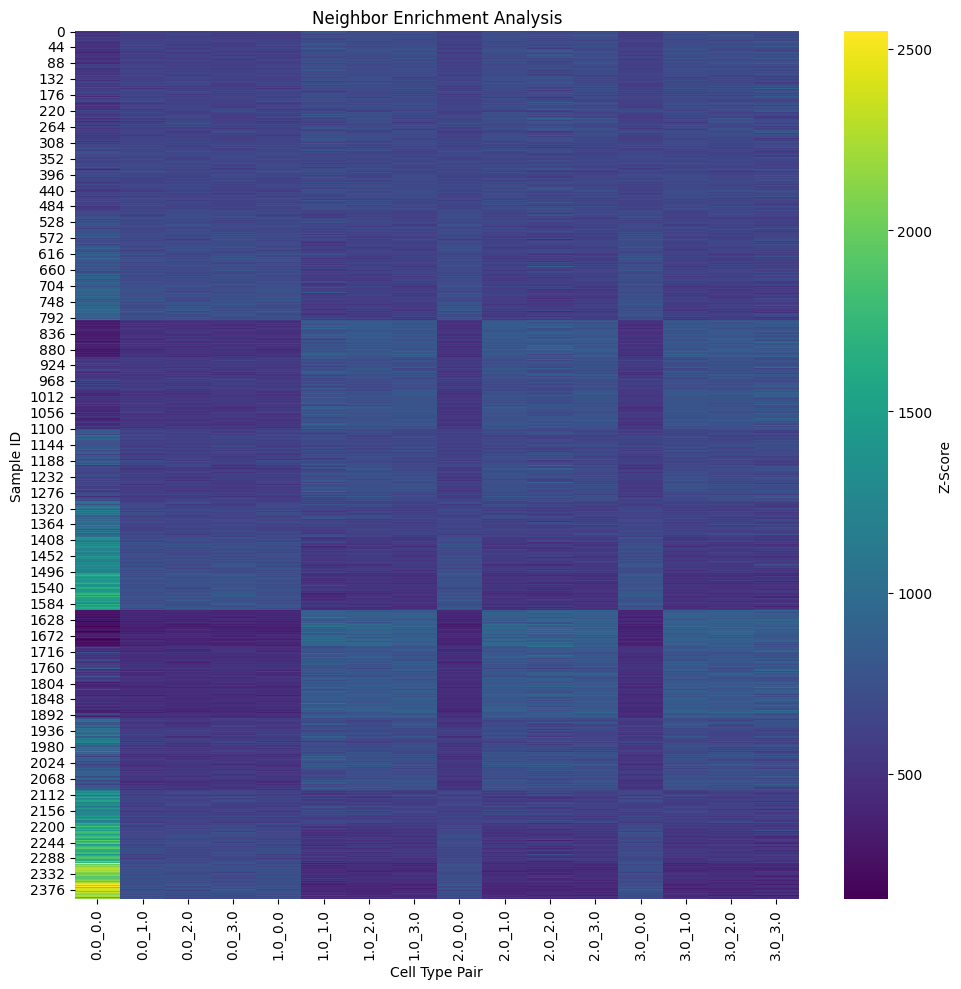

In [51]:

# Plot the heatmap
final_dataframe = final_dataframe.iloc[:, 1:]
plt.figure(figsize=(10, 10))
sns.heatmap(final_dataframe, cmap="viridis", cbar_kws={'label': 'Z-Score'})
plt.title("Neighbor Enrichment Analysis")
plt.xlabel("Cell Type Pair")
plt.ylabel("Sample ID")
plt.tight_layout()
plt.show()